# Assignment 7: Backpropagation
Read the Rojas book (https://page.mi.fu-berlin.de/rojas/neural/neuron.pdf), chapter 7.3.3 and learn about the "matrix way" of implementing backprop. 

## Ex. 7.1 XOR
Implement a two-layer artificial neural network with two input neurons and one output neuron. Choose the number of hidden neurons to your liking and add an error "neuron" to your network. Our goal is to learn the XOR function. What does the network return for random weights of all combinations of (binary) inputs? **(RESULT)**

In [1]:
# WTF is an ERROR NEURON? :D

In [2]:
import numpy as np


# Helper functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    v = sigmoid(x)
    return v * (1 - v)

def relu(x):
    x[x <= 0.0] = 0.0
    return x

def augmented(array):
    """Add ones to 0-axis."""
    shape = array.shape
    ones = np.ones((1, *shape[1:]))
    items = (array, ones)
    return np.concatenate(items, axis=0)


def unaugmented(array):
    """Inverse operation to 'augmented'."""
    return array[:-1]

In [3]:
# Datasets
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

y_and = [a & b for a, b in X]
y_or = [a | b for a, b in X]
y_xor = [a ^ b for a, b in X]

In [100]:
from typing import List

import numpy as np


class GradientDescent:
    def __init__(self, lr):
        self.lr = lr
        
    def __call__(self, weights: List[np.array], gradients: List) -> List:
        return [
            weight - self.lr * gradient
            for weight, gradient in zip(weights, gradients)
        ]

In [113]:
class Network():
    W = None
    biases = None
    
    def __init__(self, hidden, m, optimizer=GradientDescent(5.), output_dim=None):
        """
        :param hidden: number of hidden layers
        :param m: number of nodes per hidden layer
        """
        self.hidden = hidden
        self.m = m
        self.optimizer = optimizer
        self.output_dim = output_dim
    
    @staticmethod
    def init_layer(input_dim, output_dim):
        shape = (input_dim, output_dim)
        # return np.random.uniform(0, 1, shape)
        return np.random.random(shape)
    
    def initialize(self, x, y):
        if self.output_dim is None:
            self.output_dim = len(np.unique(y))
            
        input_dim = len(x[0])        
        self.W = self.init_weights(input_dim, self.output_dim, self.m)
        # The number of biases equals each weight matrix'es output_dim.
        self.biases = [np.ones(W_i.shape[1]) for W_i in self.W]
    
    def init_weights(self, input_dim, output_dim, m):
        W = []
        prev_dim = input_dim
        layer_dims = ([m] * self.hidden) + [output_dim]
        
        for layer_dim in layer_dims:
            W.append(self.init_layer(prev_dim, layer_dim))
            prev_dim = layer_dim
        return W
    
    def feed_forward(self, x):
        """
        DIFFERENT WAY OF ADDING BIASES:
        (aug = augmentation function)
        
        Rojas' book:
        O.T * W = y.T
        
        O1  ~> aug(O1) * aug(W_1) = y1 ~> s(y1) = O2
        40x1    41x1      41x50    50x1   50x1   50x1
        
        
        This is equal to
        O1  ~>  O1 * W_1  =  y1 + bias ~> s(y1) = O2
        40x    40x1 40x50   50x1  50x1    50x1
        because due to the vector-matrix multiplication 
        each entry of the last row of W_1 
        is added to each value of y1:
        y1 = [
            O1[0]*W_1[0,0] + O1[1]*W_1[1,0] + ... + O1[n]*W_1[n,0] ( + 1*W_1[n+1,0] )
            ...
            O1[m]*W_1[0,m] + O1[1]*W_1[1,m] + ... + O1[n]*W_1[n,m] ( + 1*W_1[n+1,m] )
                                                                            |
                                                                 This is where the bias would be
                                                                 added when doing it like Rojas.
        ]
        As we can see adding the bias as an extra vector does the same thing.
        """
        
        out_last = x
        outputs = [out_last]
        
        for W_i, bias in zip(self.W, self.biases):
            out_last = sigmoid((out_last @ W_i) + bias)
            outputs.append(out_last)
        return outputs
    
    def backprop(self, outputs, y_i) -> List:
        """
        HOW TO UPDATE BIASES:
        (aug = augmentation function)
        
        Rojas suggests: LR * delta * aug(O)
        
        Thus, the new bias for a given layer is the entry of the augmented
        output vector multiplied with 'delta'. Since the last entry is always 1
        'delta' itself describes the change of the biases. For that reason,
        they are appended and returned by this method as well.
        """
        gradients = []
        bias_gradients = []
        out_last = outputs[-1]
        out_last_prev = outputs[-2]
        
        e = out_last - y_i
        
        D = np.diag(sigmoid_prime(out_last))
        delta = D.dot(e)
        
        gradient = np.outer(delta, out_last_prev).T
        gradients.append(gradient)
        bias_gradients.append(delta)

        for i in reversed(range(self.hidden)):
            output_idx = i + 1
            output = outputs[output_idx]
            D = np.diag(sigmoid_prime(output))
            delta = D.dot(self.W[output_idx]).dot(delta)
            gradients.append(np.outer(delta, outputs[output_idx - 1]).T)
            bias_gradients.append(delta)
        
        gradients.reverse()
        bias_gradients.reverse()
        return gradients, bias_gradients

    def step(self, x_i, y_i):
        outputs = self.feed_forward(x_i)
        gradients, bias_gradients = self.backprop(outputs, y_i)
        self.W = self.optimizer(self.W, gradients)
        self.biases = self.optimizer(self.biases, bias_gradients)
        return outputs, gradients, bias_gradients
    
    def predict(self, x):
        out_last = self.feed_forward(x)[-1]
        out_last[out_last > .5] = 1
        out_last[out_last <= .5] = 0
        return out_last
    
    def predict_onehot(self, x):
        out_last = self.feed_forward(x)[-1]
        out_last = np.array(np.argmax(out_last) + 1)
        out_last = out_last.astype(np.float64)
        return out_last
    

In [109]:
class NetXor(Network):
    def fit_wo_backprop(self, x, y, epochs=1):
        self.initialize(x, y)
        for epoch in range(epochs):
            for x_i, y_i in zip(x, y):
                prediction = self.predict(x_i)
                print("Input: " + str(x_i) + " , Label: " + str(y_i) + " , Prediction: " + str(prediction))


'param1 : number of hidden layers, param2: m -> number of nodes per hidden layer'
net = NetXor(2, 2, GradientDescent(.55), output_dim=1)

print("####  Exercise 7.1  ####")
net.fit_wo_backprop(X, y_xor)

####  Exercise 7.1  ####
Input: [0 0] , Label: 0 , Prediction: [1.]
Input: [0 1] , Label: 1 , Prediction: [1.]
Input: [1 0] , Label: 1 , Prediction: [1.]
Input: [1 1] , Label: 0 , Prediction: [1.]


## Ex. 7.2 Backpropagation
Implement Backpropagation and optimize the weights of your neural network using the XOR training set: 

#### x, y

(0,0), 0 

(0,1), 1

(1,0), 1

(1,1), 0

How many training iterations do you need? Plot the network error over the number of iterations! **(RESULT)**

**We (usually) needed around 50-70 iterations with a standard gradient descent learning rate of 0.55.**

**Error = 1 - Accuracy**

In [114]:
class NetBackProp(Network):
    'TODO: fix to old version'
    def fit_with_backprop(self, x, y, epochs):
        self.initialize(x, y)
        
        for epoch in range(epochs):
            print("Epoch: " + str(epoch))
            predict_true = 0
            predict_false = 0
            
            for x_i, y_i in zip(x, y):
                self.step(x_i, y_i)
                prediction = self.predict(x_i)
                
                if prediction == y_i:
                    predict_true += 1
                else:
                    predict_false += 1
                    
                print("Input: " + str(x_i) + ", Label: " + str(y_i) + ", Prediction: " + str(prediction))
                
            accuracy = predict_true / (predict_true + predict_false)   
            print("predicttrue: " + str(predict_true) + "; predictfalse: " + str(predict_false))
            print("Accuracy after epoch {}: {}".format(epoch, accuracy))


print("####  Exercise 7.2  ####")
net = NetBackProp(2, 2, GradientDescent(.55), output_dim=1)
net.fit_with_backprop(X, y_xor, 200)

####  Exercise 7.2  ####
Epoch: 0
Input: [0 0], Label: 0, Prediction: [1.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 2; predictfalse: 2
Accuracy after epoch 0: 0.5
Epoch: 1
Input: [0 0], Label: 0, Prediction: [1.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 2; predictfalse: 2
Accuracy after epoch 1: 0.5
Epoch: 2
Input: [0 0], Label: 0, Prediction: [1.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 2; predictfalse: 2
Accuracy after epoch 2: 0.5
Epoch: 3
Input: [0 0], Label: 0, Prediction: [1.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 2; predictfalse: 2
Accuracy after epoch 3: 0.5
Epoch: 4
Input: [0 0], Label: 0, Prediction

Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 3; predictfalse: 1
Accuracy after epoch 77: 0.75
Epoch: 78
Input: [0 0], Label: 0, Prediction: [0.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 3; predictfalse: 1
Accuracy after epoch 78: 0.75
Epoch: 79
Input: [0 0], Label: 0, Prediction: [0.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 3; predictfalse: 1
Accuracy after epoch 79: 0.75
Epoch: 80
Input: [0 0], Label: 0, Prediction: [0.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 3; predictfalse: 1
Accuracy after epoch 80: 0.75
Epoch: 81
Input: [0 0], Label: 0, Prediction: [0.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], L

Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 3; predictfalse: 1
Accuracy after epoch 120: 0.75
Epoch: 121
Input: [0 0], Label: 0, Prediction: [0.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 3; predictfalse: 1
Accuracy after epoch 121: 0.75
Epoch: 122
Input: [0 0], Label: 0, Prediction: [0.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 3; predictfalse: 1
Accuracy after epoch 122: 0.75
Epoch: 123
Input: [0 0], Label: 0, Prediction: [0.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 3; predictfalse: 1
Accuracy after epoch 123: 0.75
Epoch: 124
Input: [0 0], Label: 0, Prediction: [0.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: 

Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 3; predictfalse: 1
Accuracy after epoch 175: 0.75
Epoch: 176
Input: [0 0], Label: 0, Prediction: [0.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 3; predictfalse: 1
Accuracy after epoch 176: 0.75
Epoch: 177
Input: [0 0], Label: 0, Prediction: [0.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 3; predictfalse: 1
Accuracy after epoch 177: 0.75
Epoch: 178
Input: [0 0], Label: 0, Prediction: [0.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: [1 0], Label: 1, Prediction: [1.]
Input: [1 1], Label: 0, Prediction: [1.]
predicttrue: 3; predictfalse: 1
Accuracy after epoch 178: 0.75
Epoch: 179
Input: [0 0], Label: 0, Prediction: [0.]
Input: [0 1], Label: 1, Prediction: [1.]
Input: 

# Ex. 7.3 MNIST (BONUS)
Train your network on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) and state the model accuracy (or the model error) for the training and test sets. **(RESULT)** Compare to this [list](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354)


(60000, 28, 28)
(60000,)
4.0


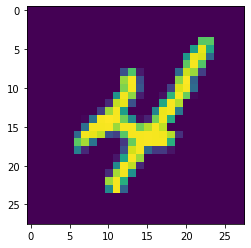

In [48]:
import torch
import torchvision
from PIL import Image
from matplotlib import pyplot as plt

mnist_data = torchvision.datasets.MNIST('./MNIST', train=True, transform=None, target_transform=None, download=True)
#data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=4, shuffle=True, num_workers=2)


# Get data as numpy
np_images = np.empty([len(mnist_data), 28, 28])
np_labels = np.empty([len(mnist_data)])

for i, (image, label) in enumerate(mnist_data):
    data = (image, label)
    np_images[i] = np.array(image)
    np_labels[i] = label
    
print(np_images.shape)
print(np_labels.shape)

#Flatten images first
images_flat = np_images.reshape(-1, 28*28)

#Normalize
images_flat = images_flat[:] / 255

# Show one example
print(np_labels[9])
plt.imshow(np_images[9])
plt.show()

In [116]:
import sys

import numpy as np


class NetMnist(Network):
    def fit_mnist(self, x, y, epochs):
        self.initialize(x, y)
        
        for epoch in range(epochs):
            i = 0
            print("Epoch: " + str(epoch))
            predict_true = 0
            predict_false = 0
            nums = set()
            
            for x_i, y_i in zip(x, y):
                outputs, gradients, bias_gradients = self.step(x_i, y_i)
                
                # onehot encoding on the fly for mnist
                if self.output_dim != 1:
                    max_value = np.argmax(outputs[-1])
                    nums.add(max_value)
                    y_i_oh = np.zeros((10,))
                    y_i_oh[max_value] = 1.0
                
                prediction = self.predict_onehot(x_i)
                
                if prediction == y_i:
                    predict_true += 1
                else:
                    predict_false += 1

                i += 1
            print(nums)
            
            accuracy = predict_true/(predict_true+predict_false)   
            print("predicttrue: " + str(predict_true) + "; predictfalse: " + str(predict_false))
            print("Accuracy after epoch {}: {}".format(epoch, accuracy))

print("####  Exercise 7.3  ####")
net_mnist = NetMnist(hidden=2, m=3, optimizer=GradientDescent(.55), output_dim=10)
net_mnist.fit_mnist(images_flat, np_labels, epochs=6)

####  Exercise 7.3  ####
Epoch: 0
{0, 1, 6}
predicttrue: 6737; predictfalse: 53263
Accuracy after epoch 0: 0.11228333333333333
Epoch: 1
{0}
predicttrue: 6742; predictfalse: 53258
Accuracy after epoch 1: 0.11236666666666667
Epoch: 2
{0}
predicttrue: 6742; predictfalse: 53258
Accuracy after epoch 2: 0.11236666666666667
Epoch: 3
{0}
predicttrue: 6742; predictfalse: 53258
Accuracy after epoch 3: 0.11236666666666667
Epoch: 4
{0}
predicttrue: 6742; predictfalse: 53258
Accuracy after epoch 4: 0.11236666666666667
Epoch: 5
{0}
predicttrue: 6742; predictfalse: 53258
Accuracy after epoch 5: 0.11236666666666667


In [ ]:
#PROBLEM: Gradients[0] sind alle null. => Daher kein Learning.

## Alternative Solution (closer to Rojas)

In [135]:
# UTILS
from collections import Counter
import math

import numpy as np
import numpy.linalg
import numpy.matlib


def hot_one_encode_ints(num_classes, ints):
    """
    'ints' May also be a single int.
    """
    # See https://stackoverflow.com/a/42874726/6928824
    targets = np.array(ints).reshape(-1)
    one_hot_targets = np.eye(num_classes)[targets]
    return one_hot_targets.reshape(-1)


def hot_one_decode_int(encoded):
    return np.argmax(encoded, axis=0)


def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))


def sigmoid_d(x):
    return sigmoid(x) * (1 - sigmoid(x))


def relu(x):
    return np.clip(x, 0, np.inf)


def relu_d(x):
    return (x >= 0).astype(float)


def augmented(array, append=True):
    """Add ones to 0-axis."""
    shape = array.shape
    ones = np.ones((1, *shape[1:]))
    if append:
        items = (array, ones)
    else:
        items = (ones, array)
    return np.concatenate(items, axis=0)


def unaugmented(array, appended=True):
    """Inverse operation to 'augmented'."""
    if appended:
        s = np.s_[:-1]
    else:
        s = np.s_[1:]
    return array[s]




# CLASSIFIER
from abc import ABC, abstractmethod

import numpy as np


class Classifier(ABC):
    """
    Abstract superclass for all classifiers
    """

    def __init__(self, X, y, num_classes=None):
        self.X = X
        self.y = y
        self.num_classes = num_classes or len(set(y))

    @classmethod
    def trained(cls, X, y):
        instance = cls(X, y)
        instance.train(X, y)
        return instance

    @abstractmethod
    def train(self, X, y):
        pass

    @abstractmethod
    def predict_label(self, x_test):
        pass

    def get_confusion_matrix(self, X_test, y_test, shape=None, **kwargs):
        if shape is None:
            shape = (self.num_classes, self.num_classes)
        matrix = np.zeros(shape=shape)
        for i, x in enumerate(X_test):
            true_label = int(y_test[i])
#             print(true_label, type(true_label))
            predicted_label = self.predict_label(x, **kwargs)
            matrix[true_label][predicted_label] += 1
        return matrix

    def print_confusion_matrix(self, X_test, y_test):
        matrix = self.get_confusion_matrix(X_test, y_test)
        print(matrix)
        print('accuracy: {}'.format(self.accuracy(X_test, y_test, matrix)))
        return matrix

    def accuracy(self, X_test, y_test, matrix=None, **kwargs):
        if matrix is None:
            matrix = self.get_confusion_matrix(X_test, y_test, **kwargs)
        return np.sum(np.diag(matrix)) / len(X_test)




# NETWORK
import math
from typing import Any, Callable, List, Tuple

import numpy as np


class BatchMethod:
    BATCH = 0
    MINI_BATCH = 1
    ONLINE_BATCH = 2


class NeuralNetwork(Classifier):
    learning_constant = 1e-3

    def __init__(self, X, y,
                 size_in: int, size_out: int,
                 hidden_layers: List[int],
                 hot_one_encode_y: Callable[[int, Any], np.ndarray] = hot_one_encode_ints,
                 hot_one_decode: Callable[[np.ndarray], int] = hot_one_decode_int):
        """
        'size_in' Number of features.
        'size_out' Number of classes.
        'hidden_layers' Defines how many nodes each layer has.
        'hot_one_encode_y' Hot-one encodes a label.
        """
        super().__init__(X, y, num_classes=size_out)
        assert len(hidden_layers) > 0, 'Need at least 1 hidden layer.'

        self.size_in = size_in
        self.size_out = size_out
        self.hidden_layers = hidden_layers
        self.hot_one_encode_y = hot_one_encode_y
        self.hot_one_decode = hot_one_decode

    def train(self, X, y, *,
              num_epochs=10,
              batch_method=BatchMethod.MINI_BATCH,
              batch_size=None,
              learning_constant=1e-3,
              callback=None):
        N = len(X)
        if batch_method == BatchMethod.MINI_BATCH:
            if batch_size is None:
                batch_size = N // 20
        elif batch_method == BatchMethod.BATCH:
            batch_size = N
            if batch_size is not None:
                print('WARNING: batch_size given but ignored.')
        elif batch_method == BatchMethod.ONLINE_BATCH:
            batch_size = 1
            if batch_size is not None:
                print('WARNING: batch_size given but ignored.')
        else:
            raise ValueError('Invalid batch method.')

        X_shuffled = X[:]
        np.random.shuffle(X_shuffled)

        weights, augmented_weights = self._initialize_weight_matrices()
        num_batches = math.ceil(N / batch_size)
        for epoch in range(num_epochs):
            for batch_index in range(num_batches):
                batch = X_shuffled[batch_index:(batch_index + batch_size)]
                corrections = [
                    np.zeros(matrix.shape)
                    for matrix in augmented_weights
                ]
                for i, x in enumerate(batch):
                    new_corrections = self.backpropagation(
                        weights,
                        *self.feed_forward(augmented_weights, x, y[i]),
                        learning_constant=learning_constant,
                    )
                    corrections = self._sum_matrix_lists(
                        corrections,
                        new_corrections
                    )

                weights, augmented_weights = self._apply_weight_corrections(
                    augmented_weights,
                    corrections
                )
            print(f'epoch {epoch + 1} done')
            if callable(callback):
                callback(augmented_weights)

        self.weights = augmented_weights

    def feed_forward(self, weights, x, y_i):
        outputs = [self._O_hat(x)]
        diagonals = []
        s = sigmoid
        sd = sigmoid_d

        # Start at 1 to match math notation.
        for i, augmented_matrix in enumerate(weights, start=1):
            O_hat_prev = outputs[i - 1]
            W = augmented_matrix
            O = s(O_hat_prev.T @ W)
            D = np.diag(sd(O))

            outputs.append(self._O_hat(O))
            diagonals.append(D)
        try:
            t = self.hot_one_encode_y(self.num_classes, int(y_i))
        except IndexError as e:
            raise ValueError((
                'Cannot hot one encode "{}" because too few outputs '
                '(change "size_out" argument for "__init__")'
            ).format(int(y_i))) from e

        # O is the final (unaugmented) output.
        error = O - t
        return outputs, diagonals, error

    def backpropagation(self, weights, outputs, diagonals, error,
                        *,
                        learning_constant):
        """
        'weights' Weight matrices W_i.
        'outputs' Augmented output vectors.
        'diagonals' Diagonal matrices D_i containing derivates
        'error' Error derivate vector e
        """
        N = len(diagonals)
        deltas = []
        i_max = N - 1
        for i in range(i_max, -1, -1):
            D = diagonals[i]
            if i == i_max:
                delta = D @ error
            else:
                W = weights[i + 1]
                delta = D @ W @ prev_delta
            # Prepend delta to keep order equal to the other variables.
            deltas.insert(0, delta)
            prev_delta = delta

        # The corrections' indices must be ascending
        # to match the order of weight matrices.
        return [
            -learning_constant * np.outer(delta, outputs[i]).T
            for i, delta in enumerate(deltas)
        ]

    def predict_label(self, x_test, weights=None):
        """
        'weights' Override self.weights, used for accuracy measurement.
        """
        if weights is None:
            weights = self.weights

        O_hat_prev = self._O_hat(x_test)
        s = sigmoid

        # Start at 1 to match math notation.
        for i, augmented_matrix in enumerate(weights, start=1):
            W = augmented_matrix
            O = s(O_hat_prev.T @ W)
            O_hat_prev = self._O_hat(O)

        return self.hot_one_decode(O)

    def _initialize_weight_matrices(self) -> Tuple[List[np.ndarray]]:
        matrices = []
        prev_dim_size = self.size_in
        for layer_size in self.hidden_layers:
            shape = (prev_dim_size, layer_size)
            matrix = np.random.uniform(0, 1, shape)
            matrices.append(matrix)
            prev_dim_size = layer_size

        shape = (prev_dim_size, self.size_out)
        matrix = np.random.uniform(0, 1, shape)
        matrices.append(matrix)
        return matrices, [augmented(matrix) for matrix in matrices]

    def _apply_weight_corrections(self, augmented_weights, corrections):
        corrected_weights = self._sum_matrix_lists(
            augmented_weights,
            corrections
        )
        return (
            [unaugmented(matrix) for matrix in corrected_weights],
            corrected_weights,
        )

    def _sum_matrix_lists(self, a, b):
        # TODO: Use zip
        if len(a) != len(b):
            raise ValueError('Unequally long lists.')
        return [a_i + b[i] for i, a_i in enumerate(a)]

    def _O_hat(self, O):
        return augmented(O)


####  Exercise 7.3b  ####
(10000, 28, 28)
(10000,)
epoch 1 done
accuracy 0.1135
epoch 2 done
accuracy 0.1135
epoch 3 done
accuracy 0.1135
epoch 4 done
accuracy 0.1135
epoch 5 done
accuracy 0.1135


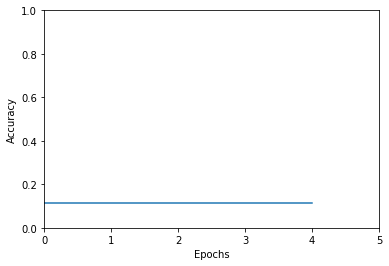

In [137]:
import matplotlib.pyplot as plt


print("####  Exercise 7.3b  ####")

mnist_data_test = torchvision.datasets.MNIST('./MNIST', train=False, transform=None, target_transform=None, download=True)
# Get data as numpy
np_images_test = np.empty([len(mnist_data_test), 28, 28])
np_labels_test = np.empty([len(mnist_data_test)])

for i, (image, label) in enumerate(mnist_data_test):
    data = (image, label)
    np_images_test[i] = np.array(image)
    np_labels_test[i] = label
    
print(np_images_test.shape)
print(np_labels_test.shape)

#Flatten images first
images_flat_test = np_images_test.reshape(-1, 28*28)

#Normalize
images_flat_test = images_flat_test[:] / 255


accuracies = []
NUM_EPOCHS=5

def cb(weights):
    acc = net_mnist_b.accuracy(images_flat_test, np_labels_test, weights=weights)
    print('accuracy', acc)
    accuracies.append(acc)

net_mnist_b = NeuralNetwork(images_flat, np_labels, 28*28, 10, [30, 20])
net_mnist_b.train(
    images_flat, np_labels,
    batch_size=32,
    learning_constant=1e-2,
    num_epochs=NUM_EPOCHS,
    callback=cb,
)
plt.plot(accuracies)
plt.axis([0, NUM_EPOCHS, 0, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()